In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import math
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.fftpack import fft, fftfreq,ifft, fft2, ifft2

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The **annual maxima are supposed to fit a normal probability density function**. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



Fifty wind: 32.97989844019469


Text(0, 0.5, 'Cumulative')

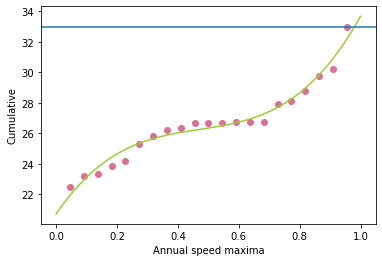

In [2]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

pi = (np.arange(years_nb) + 1)/(years_nb + 1) #cprob

spline = UnivariateSpline(pi,np.sort(max_speeds))
x = np.linspace(0,1,1000)
plt.plot(x,spline(x),color="yellowgreen")
plt.scatter(pi, np.sort(max_speeds),color="palevioletred")

fifty_prob = 1. - 0.02
fifty_wind =spline(fifty_prob)
print("Fifty wind:",fifty_wind)
plt.axhline(y=fifty_wind)
plt.xlabel("Annual speed maxima")
plt.ylabel("Cumulative")

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

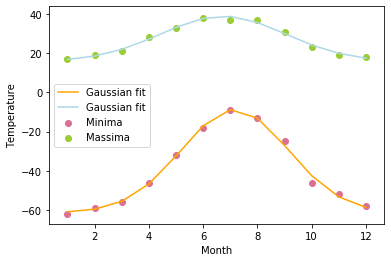

In [3]:
Tmax=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
Tmin=np.array([ -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

month=np.arange(1,12+1,1)
plt.scatter(month,Tmin,color="palevioletred",label="Minima")
plt.scatter(month,Tmax,color="yellowgreen",label="Massima")


def g(x,A,mu,sigma,offset):
    return A*np.exp((-(x-mu)*(x-mu))/(2*sigma*sigma)) + offset

params_m, params_cov_m = curve_fit(g,month,Tmin)
params_M, params_cov_M = curve_fit(g,month,Tmax)

plt.plot(month,g(month,params_m[0],params_m[1],params_m[2], params_m[3]), color="orange", label ="Gaussian fit")
plt.plot(month,g(month,params_M[0],params_M[1],params_M[2],params_M[3]), color="lightblue", label ="Gaussian fit")
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.legend()

* Is the time offset for min and max temperatures the same within the fit accuracy?

To answer this question we can apply a t-Test in order to check for the compatibility of the means of the two Gaussians (which represents the time offset, in this case).

In [4]:
s, p = stats.ttest_ind_from_stats(params_m[1],params_m[2],len(Tmin),params_M[1],params_M[2], len(Tmax))
if p > 0.05:
    print("We accept the null hypothesis, the means are compatible\n")
    print("p-value:",p)
else:
    print("We reject the nulla hypothesis, the means are not compatible\n")
    print("p-value:",p)

We accept the null hypothesis, the means are compatible

p-value: 0.6286646362353486


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [5]:
def six_hump_camelback(point):
    x=point[0]
    y=point[1]
    return (4 -2.1*x**2 + (x**4)/3)*(x**2) + x*y + (4*(y**2) - 4)*(y**2)

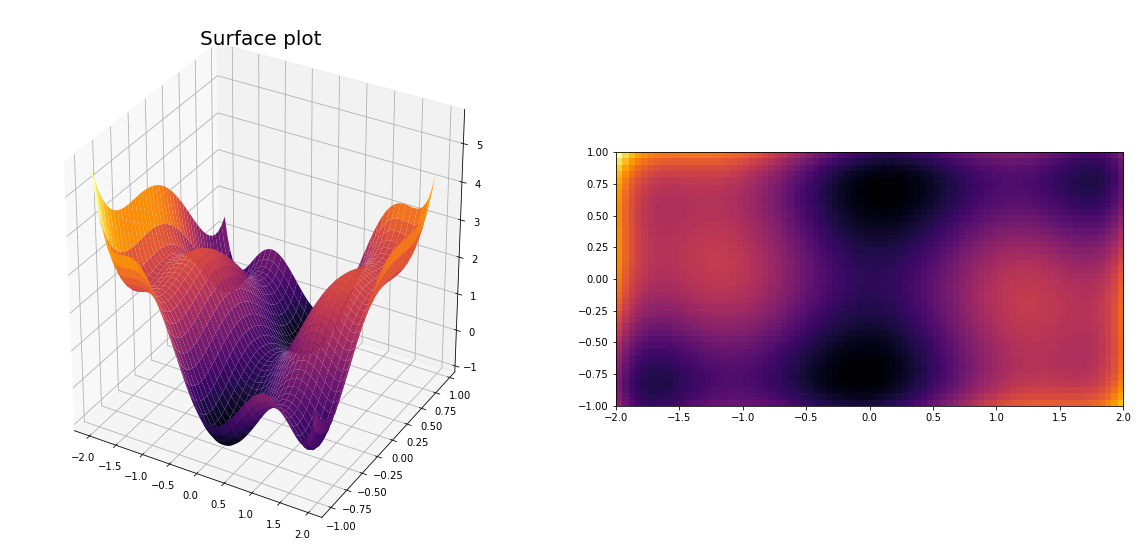

In [6]:
x = np.arange(-2, 2, 0.05) #out of those intervals nothing interesting happens
y = np.arange(-1, 1, 0.05)
xx, yy = np.meshgrid(x, y, sparse=True)
#print(xx)
#print(yy)
z = six_hump_camelback([xx,yy])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Surface plot",fontsize=20)
ax.plot_surface(xx, yy, z, cmap="inferno")

ax1 = fig.add_subplot(122)
ax1.imshow(z,cmap="inferno",extent=(-2,2,-1,1))


In [7]:
%precision 4
x0 = [[0,-0.75],[-1,0],[0,0.75],[0,0]]
mins=[]
value=[]
for start in x0:
    results = minimize(six_hump_camelback, x0=start)
    #print(results)
    mins.append(results.x)
    value.append(results.fun)

rDF = pd.DataFrame({"Starting point":x0,"Min Point": mins,"Value":value})
rDF

,Starting point,Min Point,Value
0,"[0, -0.75]","[0.08984201020477524, -0.7126564216963296]",-1.031628
1,"[-1, 0]","[-0.08984186700005968, 0.7126564775523719]",-1.031628
2,"[0, 0.75]","[-0.08984202308652081, 0.7126564083594807]",-1.031628
3,"[0, 0]","[0.0, 0.0]",0.000000


It's easy to see (even just looking at the function that we have at least two global minima since the function value is not affected if we change the sign (and not the absolute value) of both avriableas at the same time)

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

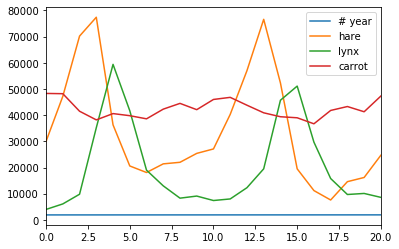

In [8]:
#! wget https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt
data = pd.read_csv('populations.txt',delimiter='\t')
data.plot()

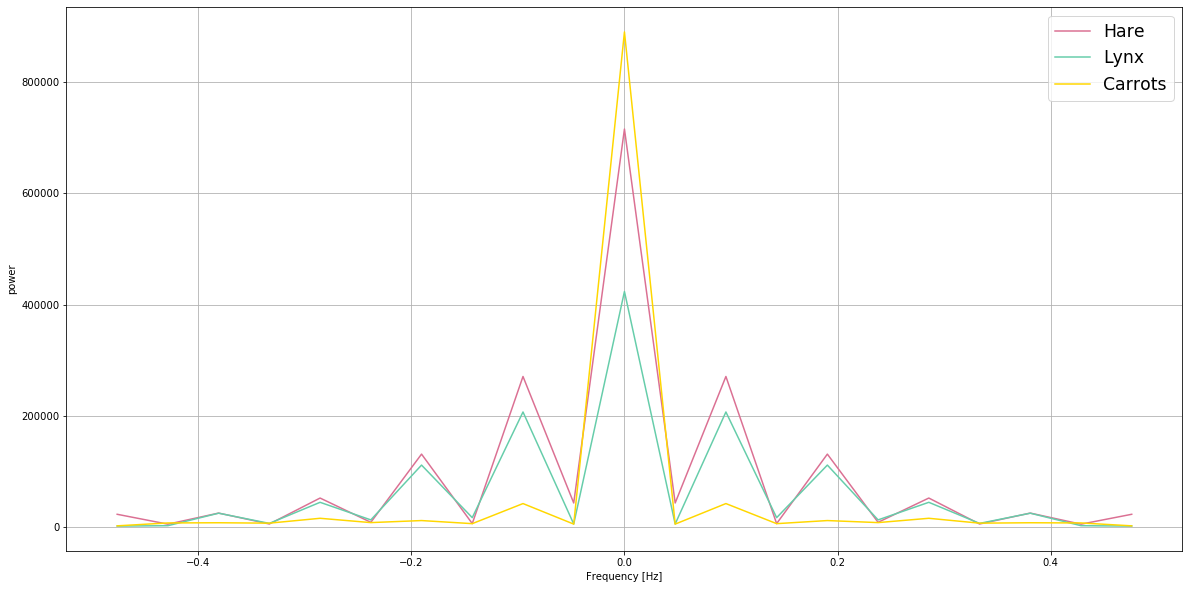

In [9]:
#FFT of the hares
hare_fft = fft(data.hare)
hare_power = np.abs(hare_fft)

#frequencies
hare_sample_freq = fftfreq(data.hare.size) #they have a weird order
rolling = np.min(np.argwhere(hare_sample_freq < 0))
hare_sample_freq = np.roll(hare_sample_freq,-rolling)  
hare_power = np.roll(np.abs(hare_fft),-rolling)


#FFT of the lynx
lynx_fft = fft(data.lynx)
lynx_power = np.abs(lynx_fft)

#frequencies
lynx_sample_freq = fftfreq(data.lynx.size) #they have a weird order
rolling = np.min(np.argwhere(lynx_sample_freq < 0))
lynx_sample_freq = np.roll(lynx_sample_freq,-rolling)  
lynx_power = np.roll(np.abs(lynx_fft),-rolling)


#FFT of the carrot
carrots_fft = fft(data.carrot)
carrots_power = np.abs(carrots_fft)

#frequencies
carrots_sample_freq = fftfreq(data.carrot.size) #they have a weird order
rolling = np.min(np.argwhere(carrots_sample_freq < 0))
carrots_sample_freq = np.roll(carrots_sample_freq,-rolling)  
carrots_power = np.roll(np.abs(carrots_fft),-rolling)

fig, (ax1)=plt.subplots(1,1,figsize=(20, 10))
ax1.plot(hare_sample_freq, hare_power, label="Hare", color="palevioletred")
ax1.grid()
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('power')
ax1.plot(lynx_sample_freq, lynx_power, label="Lynx", color="mediumaquamarine")
ax1.plot(carrots_sample_freq, carrots_power, label="Carrots", color="gold")
ax1.legend(fontsize="xx-large")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

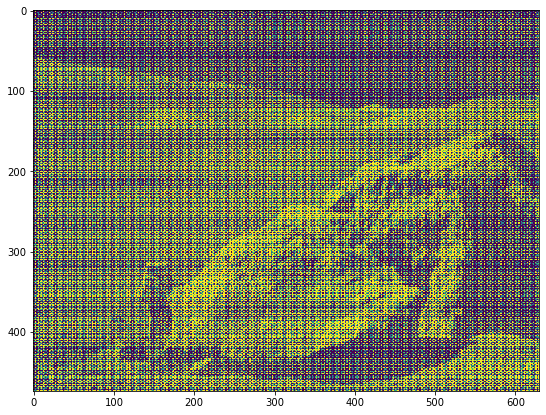

In [10]:
image = plt.imread("moonlanding.png")
fig,ax = plt.subplots(1,1, figsize=(15,7))
ax.imshow(image)

(-0.5, 629.5, 473.5, -0.5)

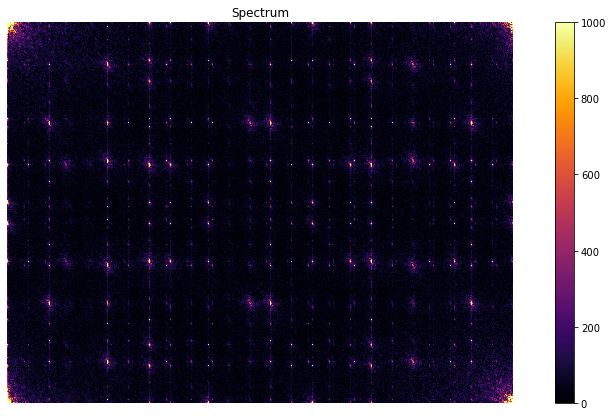

In [11]:
image_fft = fft2(image)
fig,ax = plt.subplots(1,1, figsize=(15,7))
image_power = np.abs(image_fft)
im=ax.imshow(image_power,cmap="inferno",vmin=-0, vmax=1000)
ax.set_title("Spectrum")
fig.colorbar(im)
ax.axis('off')

Text(0.5, 1.0, 'Reconstructed Image')

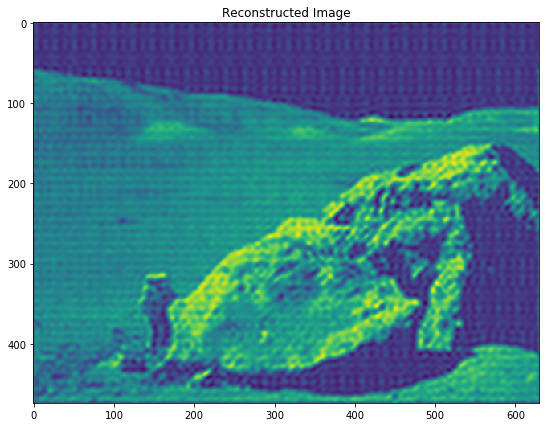

In [12]:
keep_fraction = 0.1
im_fft2 = image_fft.copy()
r, c = im_fft2.shape
# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
im_new = ifft2(im_fft2).real

plt.figure(figsize=(15,7))
plt.imshow(im_new)
plt.title('Reconstructed Image')